<a href="https://colab.research.google.com/github/PatrycjaDanilczuk/RFM-analysis-in-Python-using-access-to-BigQuery/blob/main/RFM%26Segmentation_BQ_table_plotly_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM analysis in Python using Big Query dataset and prompt user for time range selection for analysis

Project Description:

Create reusable Python code to provide Segmentation and RFM analysis of the "rfm" data table hosted in the Turing College BigQuery project.

Apply date range selection for analysis as a user prompt for the required period for analysis. When the "rfm" table is updated or incremented with new periods, the user should be able to select dates for analysis within the current data in the dataset.

For the selected date range, the code provides:

- calculation of recency, frequency and monetary values,
- visualization of recency, frequency and monetary values distribution (boxplots, histograms),
- transformation of these values into R, F and M scores using quartiles or custom cutoffs, according to the most appropriate approach based on the data distribution,
- application of Segments based on the calculated RFM score,
- data visualizations, allowing the user to make own insights.

## Step 1. Importing data from Big Query to Google Colab

### Accessing BigQuery Dataset using Google Colab

In [ ]:
#Accessing BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
project_id = 'tc-da-1'

In [ ]:
from google.cloud import bigquery

In [ ]:
client = bigquery.Client(project=project_id)
dataset_ref = client.dataset("turing_data_analytics", project = project_id)
dataset = client.get_dataset(dataset_ref)

### Getting list of tables in Dataset

In [ ]:
#Getting list of tables from BigQuery TC project
tables = list(client.list_tables(dataset))

for table in tables:
  print(table.table_id)

adsense_monthly
bank_loans_data
bank_loans_stats
cookie_cats
raw_events
rfm
rfm_quantiles
rfm_score
rfm_value
stackoverflow_posts
subscriptions
wa_marketing_campaign


In [ ]:
#accessing rfm table object, which is the 4th in the list
print(tables[5])
print(tables[5].table_id)

sql_table_id = tables[5]
sql_table_id

rfm


### Importing data to DataFrame

In [ ]:
#Importing rfm data to a DataFrame
rfm_raw_df = client.list_rows(sql_table_id).to_dataframe()

In [ ]:
rfm_raw_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.00,<NA>,United Kingdom
1,536544,22081,RIBBON REEL FLORA + FAUNA,1,2010-12-01 14:32:00+00:00,3.36,<NA>,United Kingdom
2,536544,22100,SKULLS SQUARE TISSUE BOX,1,2010-12-01 14:32:00+00:00,2.51,<NA>,United Kingdom
3,536544,22114,HOT WATER BOTTLE TEA AND SYMPATHY,3,2010-12-01 14:32:00+00:00,8.47,<NA>,United Kingdom
4,536544,22196,SMALL HEART MEASURING SPOONS,2,2010-12-01 14:32:00+00:00,1.66,<NA>,United Kingdom
...,...,...,...,...,...,...,...,...
541904,566405,23005,TRAVEL CARD WALLET I LOVE LONDON,48,2011-09-12 13:41:00+00:00,0.42,17919,United Kingdom
541905,566405,22732,3D VINTAGE CHRISTMAS STICKERS,18,2011-09-12 13:41:00+00:00,1.25,17919,United Kingdom
541906,566405,22940,FELTCRAFT CHRISTMAS FAIRY,24,2011-09-12 13:41:00+00:00,4.25,17919,United Kingdom
541907,566405,23309,SET OF 60 I LOVE LONDON CAKE CASES,48,2011-09-12 13:41:00+00:00,0.55,17919,United Kingdom


## Step 2. Exploratory data analysis

### Setting up Python enviroment for exploratory data analysis

In [ ]:
# setting up enviroment for exploratory data analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
print('Setup complete')

Setup complete


### Checking metadata, dataset quality, description, validating import results

#### Checkig columns and dtypes

In [ ]:
# getting info about the data set and data types
rfm_raw_df.info() #CustomerID need to be converted to string. Other columns have correct data type eg. InvoiceDate is datetime data type.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   InvoiceNo    541909 non-null  object             
 1   StockCode    541909 non-null  object             
 2   Description  540455 non-null  object             
 3   Quantity     541909 non-null  Int64              
 4   InvoiceDate  541909 non-null  datetime64[us, UTC]
 5   UnitPrice    541909 non-null  float64            
 6   CustomerID   406829 non-null  Int64              
 7   Country      541909 non-null  object             
dtypes: Int64(2), datetime64[us, UTC](1), float64(1), object(4)
memory usage: 34.1+ MB


#### Checkig number of rows

In [ ]:
rfm_raw_df.shape
#Validated the result with rfm table in BigQuery - there are exactly 541909 rows and 8 columns - the data set has been imported coreclly.

(541909, 8)

#### Detecting null values in the data set

In [ ]:
# detecting null values
rfm_raw_df.isnull().sum() #Instances with null values in CustomerID column need to be removed.

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### Checking data set time range

In [ ]:
# checkig time range of the data on InviceDate column
rfm_raw_df.sort_values(by='InvoiceDate', inplace=True)
rfm_raw_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430882,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00+00:00,2.75,17850,United Kingdom
430878,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom
430879,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom
430880,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00+00:00,7.65,17850,United Kingdom
430881,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom


In [ ]:
rfm_raw_df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
342461,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00+00:00,4.15,12680,France
342462,581587,22555,PLASTERS IN TIN STRONGMAN,12,2011-12-09 12:50:00+00:00,1.65,12680,France
342463,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00+00:00,0.85,12680,France
342457,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00+00:00,4.15,12680,France
342450,581587,22728,ALARM CLOCK BAKELIKE PINK,4,2011-12-09 12:50:00+00:00,3.75,12680,France


In [ ]:
#checking the earliest date in the dataframe
min_date = rfm_raw_df['InvoiceDate'].min()
min_date

Timestamp('2010-12-01 08:26:00+0000', tz='UTC')

In [ ]:
#accessing the row with the earliest date by index
min_date_index = rfm_raw_df['InvoiceDate'].idxmin()
rfm_raw_df.loc[min_date_index]

InvoiceNo                              536365
StockCode                              84406B
Description    CREAM CUPID HEARTS COAT HANGER
Quantity                                    8
InvoiceDate         2010-12-01 08:26:00+00:00
UnitPrice                                2.75
CustomerID                              17850
Country                        United Kingdom
Name: 430882, dtype: object

In [ ]:
rfm_raw_df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00+0000', tz='UTC')

In [ ]:
#accessing the row with the latest date by index
max_date_index = rfm_raw_df['InvoiceDate'].idxmax()
rfm_raw_df.loc[max_date_index]

InvoiceNo                          581587
StockCode                           22730
Description    ALARM CLOCK BAKELIKE IVORY
Quantity                                4
InvoiceDate     2011-12-09 12:50:00+00:00
UnitPrice                            3.75
CustomerID                          12680
Country                            France
Name: 342455, dtype: object

Checked with rfm BigQuery table - dates have been imported corectly.

#### Checkig data distribution

In [ ]:
# getting values distribution description
rfm_raw_df.describe() #Instances with negative values of Quanitity and Unit price need to be removed

,Quantity,UnitPrice,CustomerID
count,541909.0,541909.000000,406829.0
mean,9.55225,4.611114,15287.69057
std,218.081158,96.759853,1713.600303
min,-80995.0,-11062.060000,12346.0
25%,1.0,1.250000,13953.0
50%,3.0,2.080000,15152.0
75%,10.0,4.130000,16791.0
max,80995.0,38970.000000,18287.0


## Step 3. Cleaning data set for further analysis

In [ ]:
#creating copy of the dataframe
rfm_cleaned = rfm_raw_df.copy()

### Removing null values

In [ ]:
#remving null instances for CustomerID column
rfm_cleaned = rfm_cleaned.dropna(subset=['CustomerID'])
rfm_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
rfm_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430882,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00+00:00,2.75,17850,United Kingdom
430878,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom
430879,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom
430880,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00+00:00,7.65,17850,United Kingdom
430881,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom


In [ ]:
rfm_cleaned.shape

(406829, 8)

### Converting data types

In [ ]:
# converting CustomerID from integer to a string data type
rfm_cleaned['CustomerID'] = rfm_cleaned['CustomerID'].astype(str)
rfm_cleaned.dtypes

InvoiceNo                   object
StockCode                   object
Description                 object
Quantity                     Int64
InvoiceDate    datetime64[us, UTC]
UnitPrice                  float64
CustomerID                  object
Country                     object
dtype: object

### Removing duplicates

In [ ]:
# Check for duplicates in the entire DataFrame
duplicates = rfm_cleaned.duplicated()

In [ ]:
# Check if any row is a duplicate
if duplicates.any():
    print("DataFrame contains duplicates.")
else:
    print("DataFrame does not contain duplicates.")

DataFrame contains duplicates.


In [ ]:
#removing duplicates
rfm_cleaned = rfm_cleaned.drop_duplicates()
rfm_cleaned.shape #removed 5225 duplicated rows

(401604, 8)

### Transforming InvoiceDate to date type

In [ ]:
rfm_cleaned.dtypes

InvoiceNo                   object
StockCode                   object
Description                 object
Quantity                     Int64
InvoiceDate    datetime64[us, UTC]
UnitPrice                  float64
CustomerID                  object
Country                     object
dtype: object

In [ ]:
rfm_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430882,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00+00:00,2.75,17850,United Kingdom
430878,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom
430879,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom
430880,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00+00:00,7.65,17850,United Kingdom
430881,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00+00:00,3.39,17850,United Kingdom


In [ ]:
# InvoiceDate column is a datetime type, we can convert it to date
rfm_cleaned['InvoiceDate'] = rfm_cleaned['InvoiceDate'].dt.date

In [ ]:
rfm_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430882,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom
430878,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom
430879,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom
430880,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01,7.65,17850,United Kingdom
430881,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom


## Step 4. Selecting date range for analysis by user prompt

### Creating variables for min and max dates in the data set

Creating variable earliest_date, which will be allways the earliest date in the data set.

In [ ]:
#getting the earliest date in data set to use in teh users promot
earliest_date = rfm_cleaned['InvoiceDate'].min()
earliest_date

datetime.date(2010, 12, 1)

Creating variable latest_date, which will be allways the latest date in the data set.

In [ ]:
# getting the latest date in data set to use in the users prompt
latest_date = rfm_cleaned['InvoiceDate'].max()
latest_date

datetime.date(2011, 12, 9)

### Creating info for user of the possible time range for analysis

In [ ]:
# print info of min and max date using created earliest and latest date variables
print(f"The data set time range for RFM analysis is: {earliest_date} to {latest_date}.\n")

The data set time range for RFM analysis is: 2010-12-01 to 2011-12-09.



To create sensible analysis we will constraint the least possible period to be selected for analysis to 30 days.

In [ ]:
#printing info for user of the least time period that can be selected for analysis
print("Select time period for analysis. The shortest possible analysis period is 30 days.\n")

Select time period for analysis. The shortest possible analysis period is 30 days.



### Start date prompt

Creating input() to promot user for the start of the analysis.

The input contains information of the earliest date and the latest date of possible date range selection.

Because we want the user to select at least 30 days for the analysis, we will create start_date_constraint variable that will be latest date in the data set minus 30 days. Possible user selection for start date will be then constraint to be from earliest date in the data set to latest date in the data set minus 30 days, so that at least 30 days from strat date to end date will be possible for selection.

#### Creating start date constraint varible

In [ ]:
#creating start date constraint to use in the prompt
start_date_constraint = latest_date - timedelta(days=30)
start_date_constraint

datetime.date(2011, 11, 9)

#### Creating a loop for user start date input:
- we use earliest date in the data set and start_date_constraint variables in the input to indicate possible selection, and we indicate the required format for the input (YYYY-MM-DD),

- we "try" to convert user's input from string to date type,

- if the "try" is not successful (the input is in incorrect format), we use "except" to inform user about invalid date format and the code will loop the input() until correct format is entered,

- if the correct format is entered the code will check, if the entered date is in the possible date selection (from earliest_date to start_date_constraint),

- if enetered date is out of possible dates selection, the code will print info for user, that selected date is out of possible range and continue looping the input(),

- the code will continue looping until the date is entered in the correct format and is in the possible date range caonstraint.

In [ ]:
#creating wihle loop to loop until the user enters a date in the correct format and within the possible date range
while True:

    try:
      #prompt user for start date from earliest_date and latest_date (min and max date in the data set)
      start_date_prompt = input(f"Enter start date from: {earliest_date} to: {start_date_constraint} (format: YYYY-MM-DD): ")

      # converting users input from string to date format
      start_date_object = datetime.strptime(start_date_prompt.strip(), '%Y-%m-%d').date()

      print("Selected start date:", start_date_object)

    except ValueError:
      # printing info in case invalid format enetered
      print("Invalid date format. Please enter a date in the format YYYY-MM-DD.")
      continue

    # checking if the selected date is in the range of possible date selection (min date and max date in the data set)
    if start_date_object < earliest_date or start_date_object > start_date_constraint:
        print(f"Selected start date is out of possible range: {earliest_date} - {start_date_constraint}.")

    # break the loop if the users input is in the correct format and within the possible date range
    else:
        break

Enter start date from: 2010-12-01 to: 2011-11-09 (format: YYYY-MM-DD): jojojojjhdjh
Invalid date format. Please enter a date in the format YYYY-MM-DD.
Enter start date from: 2010-12-01 to: 2011-11-09 (format: YYYY-MM-DD):       2009-10-01
Selected start date: 2009-10-01
Selected start date is out of possible range: 2010-12-01 - 2011-11-09.
Enter start date from: 2010-12-01 to: 2011-11-09 (format: YYYY-MM-DD): 2010-12-01
Selected start date: 2010-12-01


### End date prompt

We apply the same solution for the end date prompt, except that the possible end date range selection will be from the start date selected by user (start_date_object variable created in the previous step) plus 30 days (so the selected date range is at least 30 days), to the latest date in the data set.

#### Creating end date constraint variable

In [ ]:
#Creating end date constraint variable (selected start date + 30 days)
end_date_constraint = start_date_object + timedelta(days=30)

#### Creating a loop for user end date input:
- we use end_date_constraint and latest_date variables in the input to indicate possible selection, and we indicate the required format for the input (YYYY-MM-DD),

- we "try" to convert user's input from string to date type,

- if the "try" is not successful (the input is in incorrect format), we use "except" to inform user about invalid date format and the code will loop the input() until correct format is entered,

- if the correct format is entered the code will check, if the entered date is in the possible date selection (from end_date_constraint to latest_date in the data set),

- if enetered date is out of possible dates selection, the code will print info for user, that selected date is out of possible range and continue looping the input(),

- the code will continue looping until the date is entered in the correct format and is in the possible date range caonstraint.

In [ ]:
#creating wihle loop to loop until the user enters a date in the correct format and within the possible date range
while True:

    try:
      #prompt user for end date from start date (selected already by user) and latest_date in the data set
      end_date_prompt = input(f"Enter end date from: {end_date_constraint} to {latest_date} (format: YYYY-MM-DD): ")

      # converting users input from string to date format
      end_date_object = datetime.strptime(end_date_prompt.strip(), '%Y-%m-%d').date()

      print("Selected end date:", end_date_object)

    except ValueError:
      # printing info in case invalid format enetered
      print("Invalid date format. Please enter a date in the format YYYY-MM-DD.")
      continue

    # checking if the selected date is in the range of possible  date selection (min date and max date in the data set)
    if end_date_object > latest_date or end_date_object < end_date_constraint:

        print(f"Selected end date: is out of possible range: {end_date_constraint} - {latest_date}")

    # break the loop if the users input is in the correct format and within the possible date range
    else:
        break

Enter end date from: 2010-12-31 to 2011-12-09 (format: YYYY-MM-DD): lkjdwjdj
Invalid date format. Please enter a date in the format YYYY-MM-DD.
Enter end date from: 2010-12-31 to 2011-12-09 (format: YYYY-MM-DD):      2012-10-10
Selected end date: 2012-10-10
Selected end date: is out of possible range: 2010-12-31 - 2011-12-09
Enter end date from: 2010-12-31 to 2011-12-09 (format: YYYY-MM-DD): 2011-12-09
Selected end date: 2011-12-09


### Creating data set with user's date range selection

In [ ]:
#creating data set on selected data rane if valid data selection
rfm_filtered = rfm_cleaned[(rfm_cleaned['InvoiceDate'] >= start_date_object) & (rfm_cleaned['InvoiceDate'] <= end_date_object)]

In [ ]:
rfm_filtered

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430882,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom
430878,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom
430879,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom
430880,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01,7.65,17850,United Kingdom
430881,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
342461,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France
342462,581587,22555,PLASTERS IN TIN STRONGMAN,12,2011-12-09,1.65,12680,France
342463,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,France
342457,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09,4.15,12680,France


In [ ]:
#checkig data distribution in the data set
rfm_filtered.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,401604,401604,401604,401604.0,401604,401604.000000,401604,401604
unique,22190,3684,3896,<NA>,305,NaN,4372,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,<NA>,2011-12-05,NaN,17841,United Kingdom
freq,542,2065,2058,<NA>,3359,NaN,7812,356728
mean,NaN,NaN,NaN,12.183273,NaN,3.474064,NaN,NaN
std,NaN,NaN,NaN,250.283037,NaN,69.764035,NaN,NaN
min,NaN,NaN,NaN,-80995.0,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,2.0,NaN,1.250000,NaN,NaN
50%,NaN,NaN,NaN,5.0,NaN,1.950000,NaN,NaN
75%,NaN,NaN,NaN,12.0,NaN,3.750000,NaN,NaN


## Step 5. Calculating recency, frequency and monetary

### Selecting columns for recency, frequency and monetary calculation

In [ ]:
#filtering out columns for calulations of recency, frequency and monetary
rfm_transformed = rfm_filtered[['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']]
rfm_transformed.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
430882,17850,2010-12-01,536365,8,2.75
430878,17850,2010-12-01,536365,6,3.39
430879,17850,2010-12-01,536365,6,3.39
430880,17850,2010-12-01,536365,2,7.65
430881,17850,2010-12-01,536365,6,3.39


### Creating Value column for monetary calculation (quantity * unit price)

In [ ]:
# cerating Value column for calculation of monetary
rfm_transformed['Value'] = rfm_transformed['Quantity'] * rfm_transformed['UnitPrice']

<ipython-input-147-1de332122251>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
rfm_transformed.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,Value
430882,17850,2010-12-01,536365,8,2.75,22.0
430878,17850,2010-12-01,536365,6,3.39,20.34
430879,17850,2010-12-01,536365,6,3.39,20.34
430880,17850,2010-12-01,536365,2,7.65,15.3
430881,17850,2010-12-01,536365,6,3.39,20.34


### Applying aggregations by CustomerID. Calculating Frequency and monetary.

In [ ]:
#applying aggregations to receive:
# latest invoice (for calculation of recency),
# unique count of invoices - frequency
# sum of value - monetary
# for each customer
rfm_transformed = rfm_transformed.groupby('CustomerID').agg({'InvoiceDate': 'max', 'InvoiceNo': 'nunique', 'Value': 'sum'})
rfm_transformed.head()

,InvoiceDate,InvoiceNo,Value
CustomerID,,,
12346,2011-01-18,2,0.0
12347,2011-12-07,7,4310.0
12348,2011-09-25,4,1797.24
12349,2011-11-21,1,1757.55
12350,2011-02-02,1,334.4


In [ ]:
#renaming the columns for clarity
rfm_transformed.columns = ['LatestInvoice', 'Frequency', 'Monetary']
rfm_transformed.head()

,LatestInvoice,Frequency,Monetary
CustomerID,,,
12346,2011-01-18,2,0.0
12347,2011-12-07,7,4310.0
12348,2011-09-25,4,1797.24
12349,2011-11-21,1,1757.55
12350,2011-02-02,1,334.4


### Calculating recency

In [ ]:
#calculating recency in days
today = pd.to_datetime(rfm_filtered['InvoiceDate'].max())
today

Timestamp('2011-12-09 00:00:00')

In [ ]:
rfm_transformed['LatestInvoice'] = pd.to_datetime(rfm_transformed['LatestInvoice'], errors='coerce')
rfm_transformed.dtypes

LatestInvoice    datetime64[ns]
Frequency                 int64
Monetary                Float64
dtype: object

In [ ]:
rfm_transformed['Recency'] = (today - rfm_transformed['LatestInvoice']).dt.days
rfm_transformed.head()

,LatestInvoice,Frequency,Monetary,Recency
CustomerID,,,,
12346,2011-01-18,2,0.0,325
12347,2011-12-07,7,4310.0,2
12348,2011-09-25,4,1797.24,75
12349,2011-11-21,1,1757.55,18
12350,2011-02-02,1,334.4,310


### Creating table with recency, frequency and monetary values

In [ ]:
# creating final table with calculation of recency, frequency and monetary
rfm_values = rfm_transformed[['Recency', 'Frequency', 'Monetary']]
rfm_values.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,2,0.0
12347,2,7,4310.0
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.4


### Filtering out customers with negative and 0 monetary

In [ ]:
#checking values distribution in rfm_values table
rfm_values.describe() # customers with monetary <0 should be filtered out

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.0
mean,91.581199,5.075480,1893.531433
std,100.772139,9.338754,8218.696204
min,0.000000,1.000000,-4287.63
25%,16.000000,1.000000,291.795
50%,50.000000,3.000000,644.07
75%,143.000000,5.000000,1608.335
max,373.000000,248.000000,279489.02


In [ ]:
#checking number of rows
rfm_values.shape

(4372, 3)

In [ ]:
#filtering out custmerID's with monetary < 0
rfm_values_filtered = rfm_values[(rfm_values['Monetary'] > 0)]
rfm_values_filtered.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347,2,7,4310.0
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.4
12352,36,11,1545.41


In [ ]:
#checkig distrbution in the filtered data set
rfm_values_filtered.describe() #negative Monetary values have been filtered out

,Recency,Frequency,Monetary
count,4322.000000,4322.000000,4322.0
mean,89.885932,5.115687,1918.498048
std,99.132246,9.384459,8262.489661
min,0.000000,1.000000,0.0
25%,16.000000,1.000000,300.5975
50%,49.000000,3.000000,653.325
75%,138.000000,6.000000,1624.1175
max,373.000000,248.000000,279489.02


In [ ]:
#checking dtypes in the table
rfm_values_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4322 entries, 12347 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4322 non-null   int64  
 1   Frequency  4322 non-null   int64  
 2   Monetary   4322 non-null   Float64
dtypes: Float64(1), int64(2)
memory usage: 139.3+ KB


In [ ]:
#checking numebr of instances in the table
rfm_values_filtered.shape

(4322, 3)

## Step 6. Visualization of recency, frequency and monetary values distribution

### Setting up Python enviroment for data visualisation

In [ ]:
#setting up enviroment, we will use plotly.express for visualisation
!pip install kaleido
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
print('Setup complete')

Setup complete


### Printing title for visualisations

In [ ]:
#printing title
print(f"Recency, Frequency and Monetary values distribution in the period of: {start_date_object} - {end_date_object}:\n")

Recency, Frequency and Monetary values distribution in the period of: 2010-12-01 - 2011-12-09:



### Creating boxplot and histogram for Recency

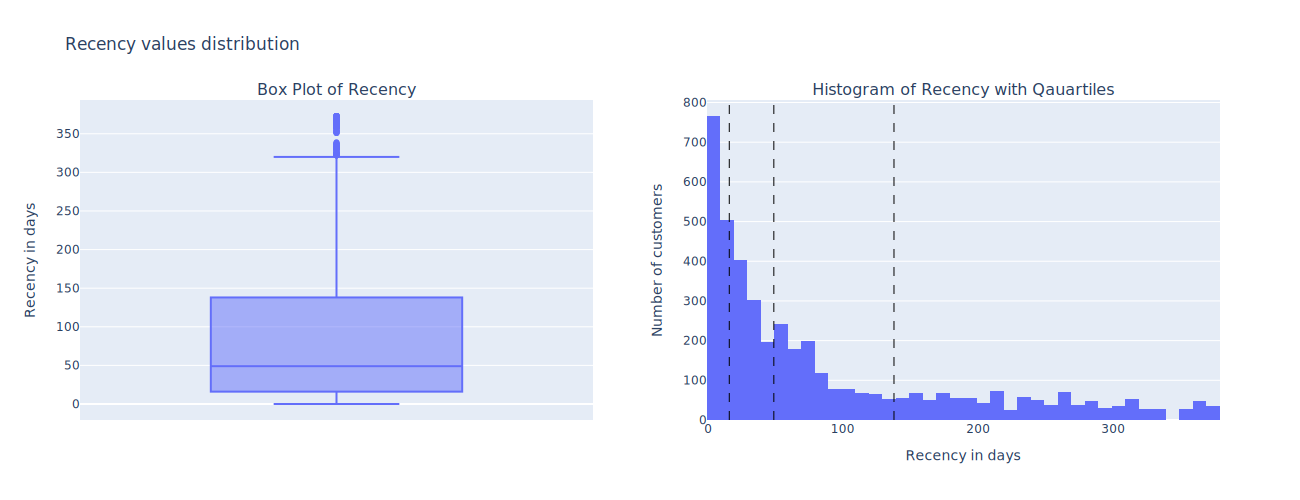

In [ ]:
# Cearing boxplot and histogram for recency
fig1 = px.box(rfm_values_filtered, y='Recency')
fig2 = px.histogram(rfm_values_filtered, x='Recency')

# Createing grid subplots with 1 row and two columns
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Box Plot of Recency', 'Histogram of Recency with Qauartiles'))

# adding recency box plot to the first subplot
for trace in fig1.data:
    #trace.line.color = 'green' - to change plot's color
    fig.add_trace(trace, row=1, col=1)

# Add recency histogram to the second subplot
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# Update layout
fig.update_layout(title='Recency values distribution',
                  showlegend=False, width=1300)

# Update yaxis label for the box plot
fig.update_yaxes(title_text='Recency in days', row=1, col=1)

# Update yaxis label for the histogram
fig.update_yaxes(title_text='Number of customers', row=1, col=2)

# update xasis label for the histogram
fig.update_xaxes(title="Recency in days", row=1, col=2)

# Compute quartiles
quartiles = np.percentile(rfm_values_filtered['Recency'], [25, 50, 75])

# Add vertical lines for quartiles
for q in quartiles:
    fig.add_vline(x=q, line=dict(color="black", width=1, dash="dash"), row=1, col=2)

!pip install kaleido

# Show figure
fig.show("svg")

### Creating boxplot and histogram for Frequency

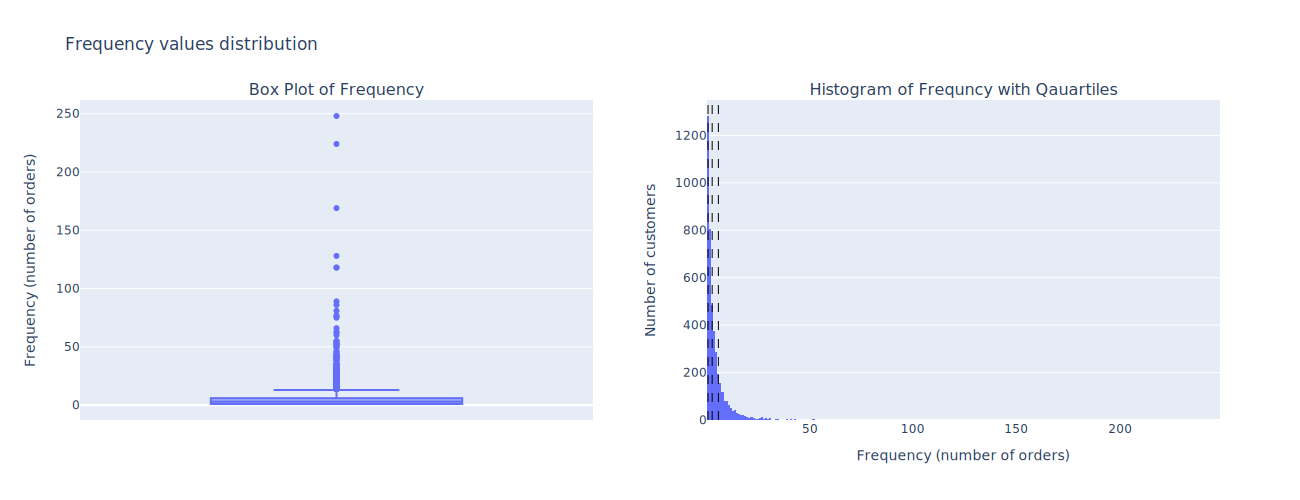

In [ ]:
# Cearing boxplot and histogram for frequency
fig1 = px.box(rfm_values_filtered, y='Frequency')
fig2 = px.histogram(rfm_values_filtered, x='Frequency')

# Createing grid subplots with 1 row and two columns
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Box Plot of Frequency', 'Histogram of Frequncy with Qauartiles'))

# adding recency box plot to the first subplot
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# Add recency histogram to the second subplot
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# Update layout
fig.update_layout(title='Frequency values distribution',
                  showlegend=False, width=1300)

# Update yaxis label for the box plot
fig.update_yaxes(title_text='Frequency (number of orders)', row=1, col=1)

# Update yaxis label for the histogram
fig.update_yaxes(title_text='Number of customers', row=1, col=2)

# update xasis label for the histogram
fig.update_xaxes(title='Frequency (number of orders)', row=1, col=2)

# Compute quartiles
quartiles = np.percentile(rfm_values_filtered['Frequency'], [25, 50, 75])

# Add vertical lines for quartiles
for q in quartiles:
    fig.add_vline(x=q, line=dict(color="black", width=1, dash="dash"), row=1, col=2)

# Show figure
fig.show("svg")

### Creating boxplot and histogram for Monetary

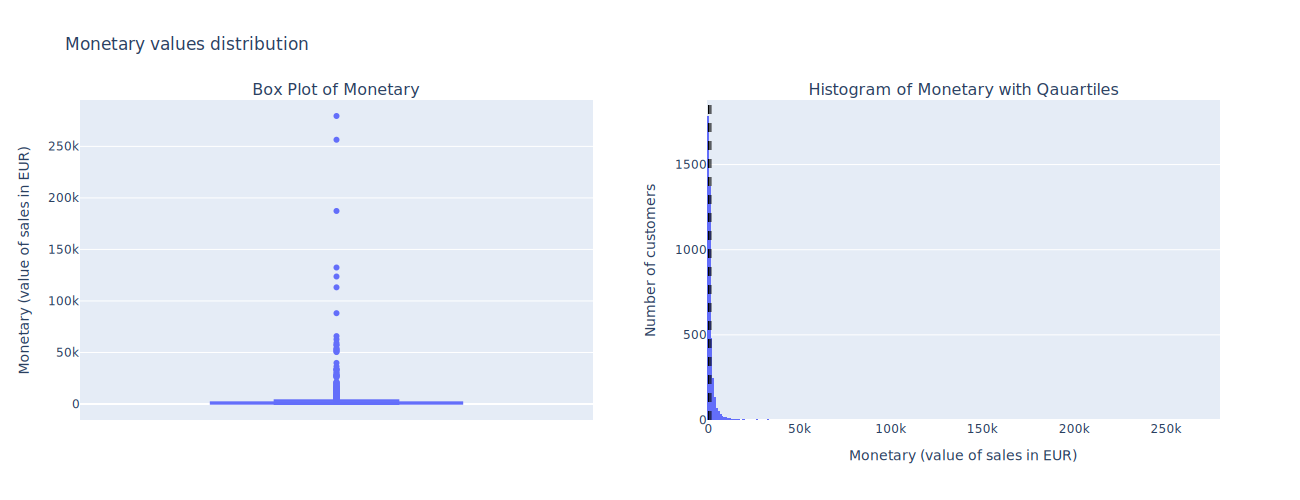

In [ ]:
# Crearing boxplot and histogram for monetary
fig1 = px.box(rfm_values_filtered, y='Monetary')
fig2 = px.histogram(rfm_values_filtered, x='Monetary')

# Createing grid subplots with 1 row and two columns
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Box Plot of Monetary', 'Histogram of Monetary with Qauartiles'))

# adding recency box plot to the first subplot
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

# Add recency histogram to the second subplot
for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

# Update layout
fig.update_layout(title='Monetary values distribution',
                  showlegend=False, width=1300)

# Update yaxis label for the box plot
fig.update_yaxes(title_text='Monetary (value of sales in EUR)', row=1, col=1)

# Update yaxis label for the histogram
fig.update_yaxes(title_text='Number of customers', row=1, col=2)

# update xasis label for the histogram
fig.update_xaxes(title='Monetary (value of sales in EUR)', row=1, col=2)

# Compute quartiles
quartiles = np.percentile(rfm_values_filtered['Monetary'], [25, 50, 75])

# Add vertical lines for quartiles
for q in quartiles:
    fig.add_vline(x=q, line=dict(color="black", width=1, dash="dash"), row=1, col=2)

# Show figure
fig.show("svg")

In [ ]:
rfm_values_filtered.describe()

,Recency,Frequency,Monetary
count,4322.000000,4322.000000,4322.0
mean,89.885932,5.115687,1918.498048
std,99.132246,9.384459,8262.489661
min,0.000000,1.000000,0.0
25%,16.000000,1.000000,300.5975
50%,49.000000,3.000000,653.325
75%,138.000000,6.000000,1624.1175
max,373.000000,248.000000,279489.02


## Step 7. Applying RFM score

### Applying recency score

Recency score is caculated using quartiles. Customers who ordered most recent are labeled "4" for recency score, customers who ordered latest are labeled "1" for recency score.

In [ ]:
#creating column for recency score and applying quartiles to divide customers into 4 bins
rfm_values_filtered['R_score'] = pd.qcut(rfm_values_filtered['Recency'], q=4, labels=range(4, 0, -1)).astype(str)
# we apply backward lablels here so that customers who orderd most recent are labeled 4 for R_score

<ipython-input-167-1cf43e23b1de>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Applying frequency score

For frequency score we need to define custom bins, because the data is not evenly distributed. Most clients ordered only once, so have frequency 1. We need to define custom bins, so that clients with similar behaviour get thesame freqency score.

We define four custom bins with the following labels:

"1" - customers with frequency 0 to 1 (included)

"2" - customers with frequency 1 to 3 (included) as the 2nd quartile for frequency is 3

"3" - customers with frequency 3 to 6 (included) as the 3rd quartile for frequency is 6

"4" - customers with frequency over 6

In [ ]:
#Creating custom bins: (0-1), (1-3), (3-6), (6 to positive infinity)
frequency_bins = [0, 1, 3, 6, np.inf]

# Defining labels for bins (n-1 bins)
frequency_labels = [1, 2, 3, 4]

# Creating a new column with the custom bin labels
rfm_values_filtered['F_score'] = pd.cut(rfm_values_filtered['Frequency'], bins=frequency_bins, labels=frequency_labels).astype(str)


<ipython-input-168-5cb2cc4a2a45>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Applying monetary score

Mnatary score is caculated using quartiles. Customers with highest monetary (highest sales values) are labeled "4" for monetary score, customers with lowest monetary (lowest sales values) are labeled "1" for monetary score.

In [ ]:
# creating new column with monetary score and applyin quartiles to divide customers into 4 bins
rfm_values_filtered['M_score'] = pd.qcut(rfm_values_filtered['Monetary'], q=4, labels=range(1, 5)).astype(str)
# customers are labeled 4 for higest monetary 1 for lowest monetary

<ipython-input-169-49f7b6c8cce1>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Creating RFM score

In [ ]:
# selecting columns for creating RFM score
rfm_scores = rfm_values_filtered[['Recency', 'Frequency', 'Monetary', 'R_score', 'F_score', 'M_score']]
rfm_scores.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score
CustomerID,,,,,,
12347,2,7,4310.0,4,4,4
12348,75,4,1797.24,2,3,4
12349,18,1,1757.55,3,1,4
12350,310,1,334.4,1,1,2
12352,36,11,1545.41,3,4,3


In [ ]:
#checking data types
rfm_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4322 entries, 12347 to 18287
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4322 non-null   int64  
 1   Frequency  4322 non-null   int64  
 2   Monetary   4322 non-null   Float64
 3   R_score    4322 non-null   object 
 4   F_score    4322 non-null   object 
 5   M_score    4322 non-null   object 
dtypes: Float64(1), int64(2), object(3)
memory usage: 240.6+ KB


In [ ]:
#creating column with RFM score
rfm_scores['RFM_score'] = rfm_scores['R_score'] + rfm_scores['F_score'] +rfm_scores['M_score']

In [ ]:
rfm_scores.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
CustomerID,,,,,,,
12347,2,7,4310.0,4,4,4,444
12348,75,4,1797.24,2,3,4,234
12349,18,1,1757.55,3,1,4,314
12350,310,1,334.4,1,1,2,112
12352,36,11,1545.41,3,4,3,343


## Step 8. Defining Segments

### Importing google sheet with defined Segments

Please note that this point is added only to display Segments description, that was prepared separately in googlesheet stored in personal drive. If you want to run the code from your enviroment, please "comment" this part, so that the remaining code (from "Creating column with segment name") could properly run in your enviromet.

In [ ]:
import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
#select the file to load
worksheet = gc.open('RFM Segments description_pdanil').sheet1

In [ ]:
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
segments_description = pd.DataFrame.from_records(rows)

#setting column names from first row
segments_description.columns = segments_description.iloc[0]

# removing first row
segments_description = segments_description[1:]
segments_description

,Segment,RFM score range,Description,Marketing strategies
1,Best customers,444,"Highly engaged customers, who have bought the ...",Focus on loyalty programs and new product intr...
2,Loyal customers,"443, 344, 343, 442, 441, 342, 334",Customers who buy the most often and spent a g...,Loyalty programs are effective for these repea...
3,Potential loyalists,"434, 433, 424, 423, 432, 431","Recent customers, spent a good amount and boug...","Offer membership, loyalty program, recommended..."
4,Recent customers,"422, 412, 421, 413, 411",Customers who bought most recently but not often,Provide on-boarding support. Give them early s...
5,Needing attention,"333, 332, 331, 324, 323, 322, 321, 313, 312, 311",Customers above average recency and frequency ...,"Dedicated offers based on previous orders, lim..."
6,At risk,"224, 233, 232, 243, 244, 234, 242, 231, 223","Customers who, made biggest purchases, often, ...",Send personalized emails to reconnect. Offer r...
7,Big spenders,"414, 314, 214, 114",Customers who have generated the most revenue ...,These customers have demonstrated a high willi...
8,About to sleep,"222, 221, 211, 213, 212, 142, 141, 132, 131, 1...",Customers below average recency frequency and ...,Share valuable resources. Recommend popular pr...
9,Can't lose them,"134, 144, 133, 143, 124, 123",Customers who spent above average amount of mo...,Win them back by renewals or new products. Rea...
10,Lost customers,111,"Customers with lowest recency, frequency and m...",Revive interest with reach out campaign. Ignor...


### Creating column with segment name

In [ ]:
# Defining conditions and corresponding segment labels
conditions = [
    (rfm_scores['RFM_score'] == '444'),
    (rfm_scores['RFM_score'] == '111'),
    (rfm_scores['RFM_score'].isin(['222', '221', '213', '212', '211', '142', '141', '132', '131', '122', '121', '113', '112'])),
    (rfm_scores['RFM_score'].isin(['244','243','242','234','233','232','231','224','223'])),
    (rfm_scores['RFM_score'].isin(['414', '314', '214', '114'])),
    (rfm_scores['RFM_score'].isin(['144','143','134','133','124','123'])),
    (rfm_scores['RFM_score'].isin(['443', '442', '441', '344', '343', '342', '334'])),
    (rfm_scores['RFM_score'].isin(['434','433','432','431','424','423'])),
    (rfm_scores['RFM_score'].isin(['422', '421', '413', '412', '411']))]

segment_labels = [
    'Best customers',
    'Lost customers',
    'About to sleep',
    'At risk',
    'Big spenders',
    "Can't lose them",
    'Loyal customers',
    'Potential loyalists',
    'Recent customers']

# Creating the Segment column based on the conditions and segment labels
rfm_scores['Segment'] = np.select(conditions, segment_labels, default='Needing attention')


In [ ]:
rfm_scores.head(10)

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,Segment
CustomerID,,,,,,,,
12347,2,7,4310.0,4,4,4,444,Best customers
12348,75,4,1797.24,2,3,4,234,At risk
12349,18,1,1757.55,3,1,4,314,Big spenders
12350,310,1,334.4,1,1,2,112,About to sleep
12352,36,11,1545.41,3,4,3,343,Loyal customers
12353,204,1,89.0,1,1,1,111,Lost customers
12354,232,1,1079.4,1,1,3,113,About to sleep
12355,214,1,459.4,1,1,2,112,About to sleep
12356,22,3,2811.43,3,2,4,324,Needing attention


## Step 9. RFM analysis and visualization

### Aggregating data by Segment

In [ ]:
#applying aggregation by segments
rfm_analysis = rfm_scores.groupby('Segment').agg(
    {'Segment': 'count', 'Recency': ['min', 'max', 'mean'], 'Frequency': ['min', 'max', 'mean'], 'Monetary': ['min', 'max', 'mean', 'sum']})

#rounding floating values and sorting by sum of monetary in descending order
rfm_analysis = rfm_analysis.round(1).sort_values(by=('Monetary', 'sum'), ascending=False)
rfm_analysis

Segment Recency             Frequency            Monetary  \
                      count     min  max   mean       min  max  mean      min   
Segment                                                                         
Best customers          442       0   16    5.9         7  248  20.1   1632.4   
Loyal customers         399       0   49   24.9         4   76   9.9    191.2   
At risk                 499      50  138   80.8         2   20   4.9    102.0   
Potential loyalists     368       0   16    7.4         2    6   4.3    151.2   
Needing attention       747      17   72   30.1         1    7   2.6      0.0   
About to sleep         1087      50  373  156.7         1    9   1.7      0.0   
Can't lose them         152     140  366  206.8         2   35   4.2    658.3   
Recent customers        212       0   16    8.1         1    3   1.8      2.9   
Big spenders             26       2  372  135.9         1    1   1.0   1635.7   
Lost customers          390     140  373  265.2         1    1   1.0      3.8   

                                                  
                          max    mean        sum  
Segment                                           
Best customers       279489.0  9388.4  4149656.1  
Loyal customers      123725.4  3588.6  1431839.1  
At risk               11581.8  1638.8   817773.5  
Potential loyalists   12393.7  1469.8   540869.8  
Needing attention      6748.8   646.9   483251.6  
About to sleep         1487.6   383.3   416613.7  
Can't lose them       21535.9  1661.2   252497.9  
Recent customers       1162.6   335.4    71102.3  
Big spenders           6207.7  2561.3    66593.8  
Lost customers          300.5   157.8    61550.7

### Data visualisation

In [ ]:
#flattening column index
rfm_analysis.columns = rfm_analysis.columns.map('_'.join)

In [ ]:
#reseting index
rfm_analysis = rfm_analysis.reset_index()
rfm_analysis

,Segment,Segment_count,Recency_min,Recency_max,Recency_mean,Frequency_min,Frequency_max,Frequency_mean,Monetary_min,Monetary_max,Monetary_mean,Monetary_sum
0,Best customers,442,0,16,5.9,7,248,20.1,1632.4,279489.0,9388.4,4149656.1
1,Loyal customers,399,0,49,24.9,4,76,9.9,191.2,123725.4,3588.6,1431839.1
2,At risk,499,50,138,80.8,2,20,4.9,102.0,11581.8,1638.8,817773.5
3,Potential loyalists,368,0,16,7.4,2,6,4.3,151.2,12393.7,1469.8,540869.8
4,Needing attention,747,17,72,30.1,1,7,2.6,0.0,6748.8,646.9,483251.6
5,About to sleep,1087,50,373,156.7,1,9,1.7,0.0,1487.6,383.3,416613.7
6,Can't lose them,152,140,366,206.8,2,35,4.2,658.3,21535.9,1661.2,252497.9
7,Recent customers,212,0,16,8.1,1,3,1.8,2.9,1162.6,335.4,71102.3
8,Big spenders,26,2,372,135.9,1,1,1.0,1635.7,6207.7,2561.3,66593.8
9,Lost customers,390,140,373,265.2,1,1,1.0,3.8,300.5,157.8,61550.7


In [ ]:
#display table for user
rfm_analysis_to_display = rfm_analysis.set_index('Segment')
print(f"RFM analysis for the period of: {start_date_object} to {end_date_object}:\n")
print(rfm_analysis_to_display)

RFM analysis for the period of: 2010-12-01 to 2011-12-09:

                     Segment_count  Recency_min  Recency_max  Recency_mean  \
Segment                                                                      
Best customers                 442            0           16           5.9   
Loyal customers                399            0           49          24.9   
At risk                        499           50          138          80.8   
Potential loyalists            368            0           16           7.4   
Needing attention              747           17           72          30.1   
About to sleep                1087           50          373         156.7   
Can't lose them                152          140          366         206.8   
Recent customers               212            0           16           8.1   
Big spenders                    26            2          372         135.9   
Lost customers                 390          140          373         265.2   

    

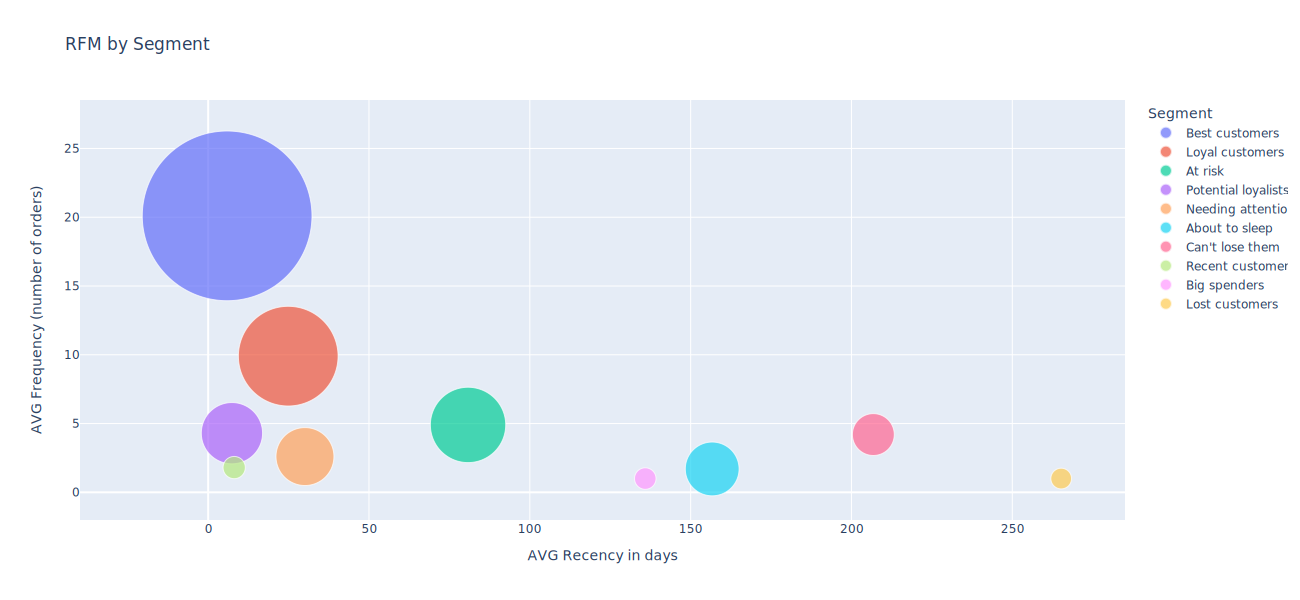

In [ ]:
# plotting avg Frequency and avg Recency in scatter plot with buble size representing Monetary sum
fig = px.scatter(rfm_analysis, x="Recency_mean", y="Frequency_mean", color="Segment",
                 hover_name="Segment", size=rfm_analysis['Monetary_sum'].tolist(), title='RFM by Segment',
                 labels={'Frequency_mean': 'AVG Frequency (number of orders)', 'Recency_mean': 'AVG Recency in days'},
                 hover_data=['Segment_count', 'Monetary_sum', 'Monetary_mean'], size_max=120, height=600, width=1300)
fig.show("svg")

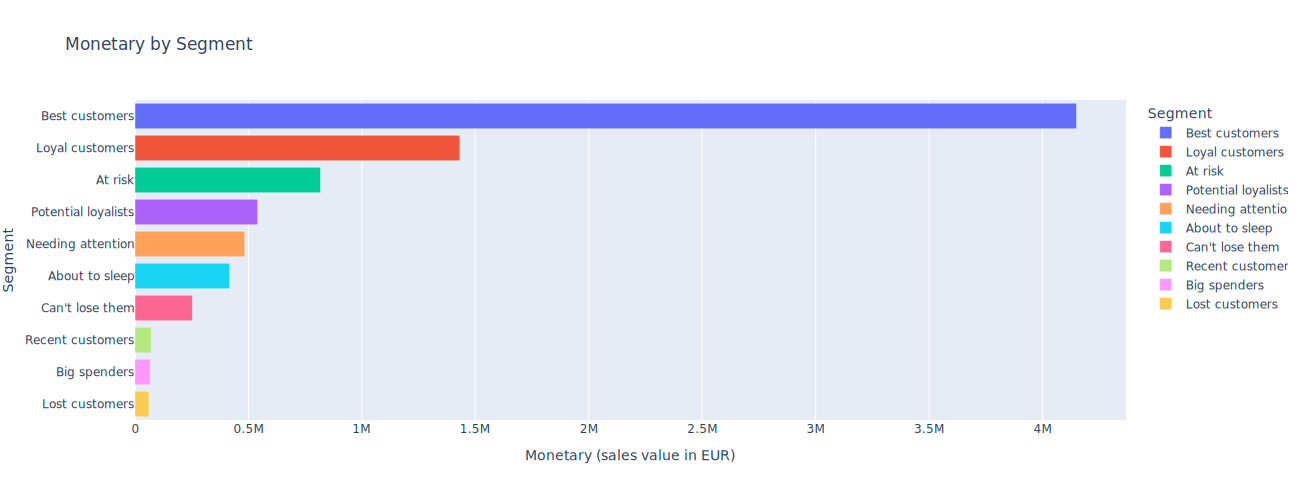

In [ ]:
#creating bar plot representing monetary sum by Segment
fig = px.bar(rfm_analysis, y='Segment', x='Monetary_sum', title='Monetary by Segment', orientation='h',
             color='Segment', color_continuous_scale='Viridis', hover_data=['Monetary_min', 'Monetary_max', 'Monetary_mean'],
             labels={'Monetary_sum': 'Monetary (sales value in EUR)'}, width=1300)
fig.show("svg")

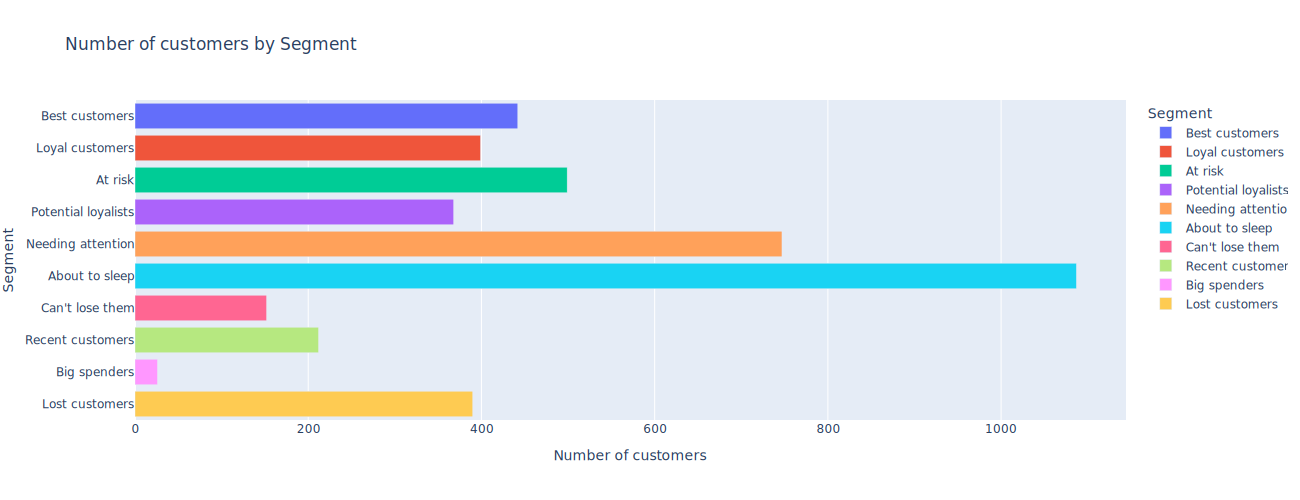

In [ ]:
#creating bar chart reoresenting number of custmers in each Segment
fig = px.bar(rfm_analysis, y='Segment', x='Segment_count', title='Number of customers by Segment', orientation='h',
             color='Segment', hover_data=['Monetary_sum', 'Recency_mean', 'Frequency_mean'],
             labels={'Segment_count': 'Number of customers'}, width=1300)
fig.show("svg")

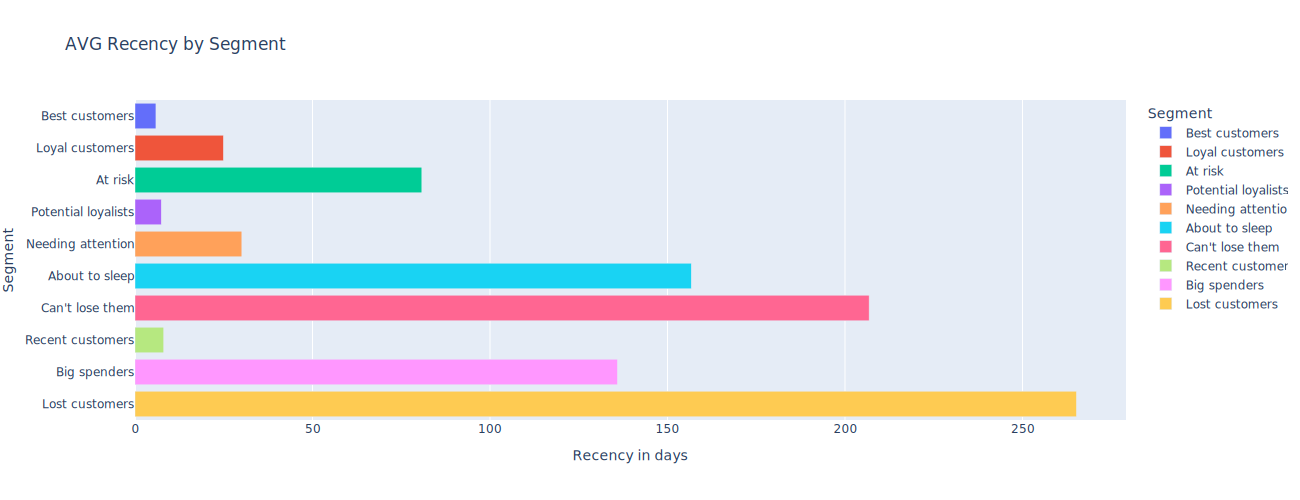

In [ ]:
#creating bar chart for avg Recency by Segment
fig = px.bar(rfm_analysis, y='Segment', x='Recency_mean', title='AVG Recency by Segment', orientation='h',
             color='Segment', color_continuous_scale='Viridis', hover_data=['Recency_min', 'Recency_max', 'Recency_mean', 'Monetary_sum', 'Segment_count'],
             labels={'Recency_mean': 'Recency in days'}, width=1300)
fig.show("svg")

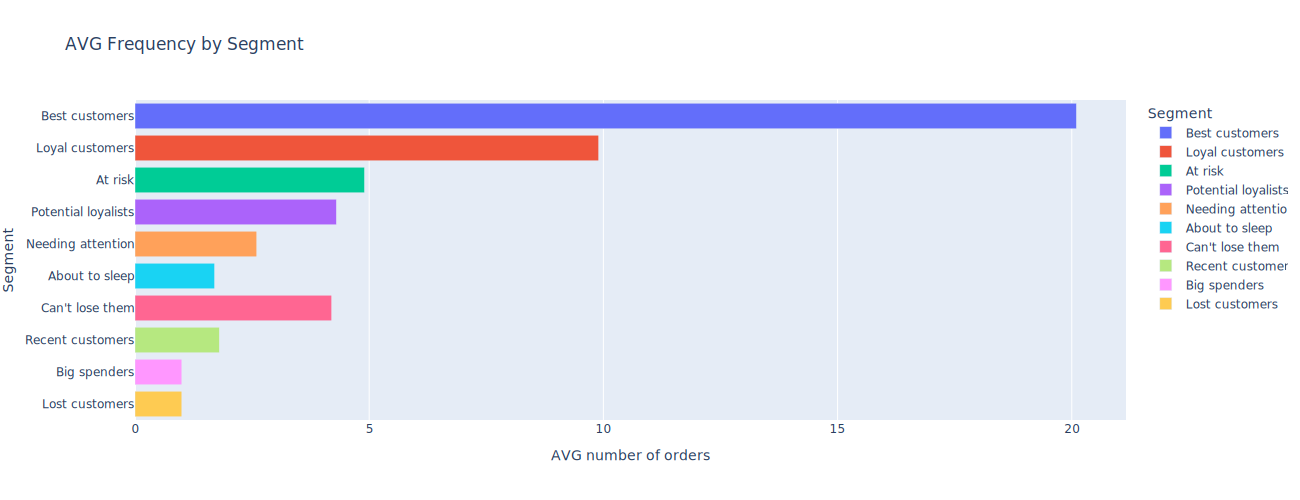

In [ ]:
#creating bar chart for avg Frequency by Segment
fig = px.bar(rfm_analysis, y='Segment', x='Frequency_mean', title='AVG Frequency by Segment', orientation='h',
             color='Segment', color_continuous_scale='Viridis', hover_data=['Frequency_min', 'Frequency_max', 'Frequency_mean', 'Monetary_sum', 'Segment_count'],
             labels={'Frequency_mean': 'AVG number of orders'}, width=1300)
fig.show("svg")

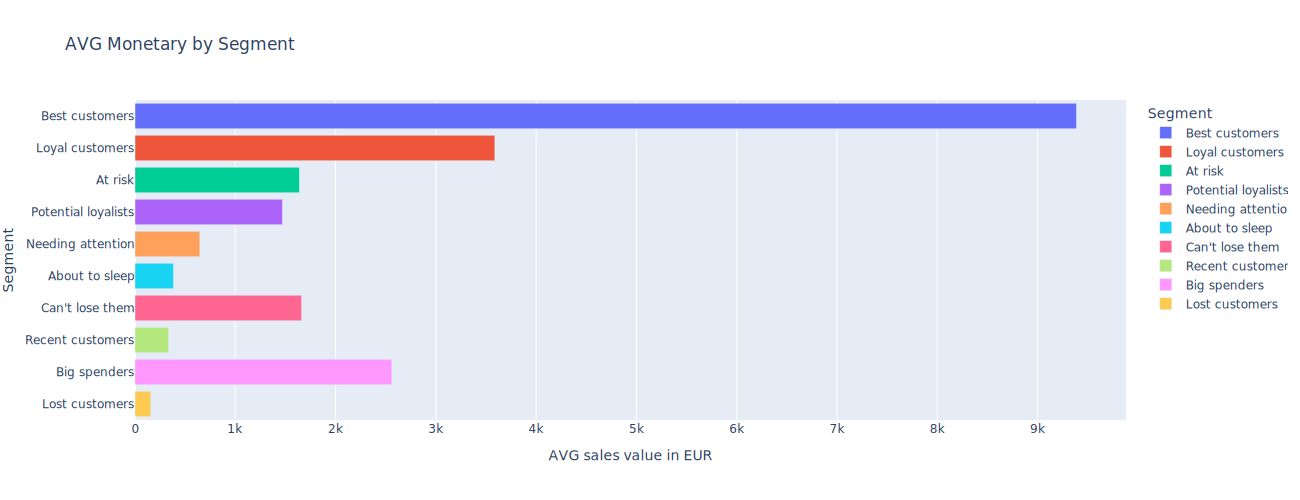

In [ ]:
#creating bar chart for avg Monetary by Segment
fig = px.bar(rfm_analysis, y='Segment', x='Monetary_mean', title='AVG Monetary by Segment', orientation='h',
             color='Segment', color_continuous_scale='Viridis', hover_data=['Monetary_min', 'Monetary_max', 'Monetary_mean', 'Monetary_sum', 'Segment_count'],
             labels={'Monetary_mean': 'AVG sales value in EUR'}, width=1300)
fig.show("svg")